# Recommending movies: retrieval

**Learning Objectives**

In this notebook, we're going to build and train a two-tower retrieval model using the Movielens dataset.

We're going to:

1. Get our data and split it into a training and test set.
2. Implement a retrieval model.
3. Fit and evaluate it.
4. Export it for efficient serving by building an approximate nearest neighbours (ANN) index.



## Introduction
Real-world recommender systems are often composed of two stages:

1. The retrieval stage is responsible for selecting an initial set of hundreds of candidates from all possible candidates. The main objective of this model is to efficiently weed out all candidates that the user is not interested in. Because the retrieval model may be dealing with millions of candidates, it has to be computationally efficient.
2. The ranking stage takes the outputs of the retrieval model and fine-tunes them to select the best possible handful of recommendations. Its task is to narrow down the set of items the user may be interested in to a shortlist of likely candidates.

In this notebook, we're going to focus on the first stage, retrieval.

Retrieval models are often composed of two sub-models:

1. A query model computing the query representation (normally a fixed-dimensionality embedding vector) using query features.
2. A candidate model computing the candidate representation (an equally-sized vector) using the candidate features

The outputs of the two models are then multiplied together to give a query-candidate affinity score, with higher scores expressing a better match between the candidate and the query.

This two sub-model architecture is called **two-tower** model.

### The dataset

The Movielens dataset is a classic dataset from the [GroupLens](https://grouplens.org/datasets/movielens/) research group at the University of Minnesota. It contains a set of ratings given to movies by a set of users, and is a workhorse of recommender system research.

The data can be treated in two ways:

1. It can be interpreted as expressesing which movies the users watched (and rated), and which they did not. This is a form of implicit feedback, where users' watches tell us which things they prefer to see and which they'd rather not see.
2. It can also be seen as expressesing how much the users liked the movies they did watch. This is a form of explicit feedback: given that a user watched a movie, we can tell roughly how much they liked by looking at the rating they have given.

In this notebook, we are focusing on a retrieval system: a model that predicts a set of movies from the catalogue that the user is likely to watch. Often, implicit data is more useful here, and so we are going to treat Movielens as an implicit system. This means that every movie a user watched is a positive example, and every movie they have not seen is an implicit negative example.

Each learning objective will correspond to a __#TODO__ in the [student lab notebook](https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/courses/machine_learning/deepdive2/recommendation_systems/solutions/basic_retrieval.ipynb) -- try to complete that notebook first before reviewing this solution notebook.


## Setup

For this lab, you'll first need to build a special kernel containing all the dependencies we will need:

In [1]:
!cd ~/asl-ml-immersion && make tf_recommenders_kernel

./kernels/tf_recommenders.sh
creating tf_recommenders_kernel at /home/jupyter/asl-ml-immersion/notebooks/recommendation_systems
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.3 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
Installed kernelspec tf_recommenders_kernel in /home/jupyter/.local/share/jupyter/kernels/tf_recommenders_kernel


Then you'll need to select the kernel in the notebook. Click on the current kernel on the top right corner of the notebook:

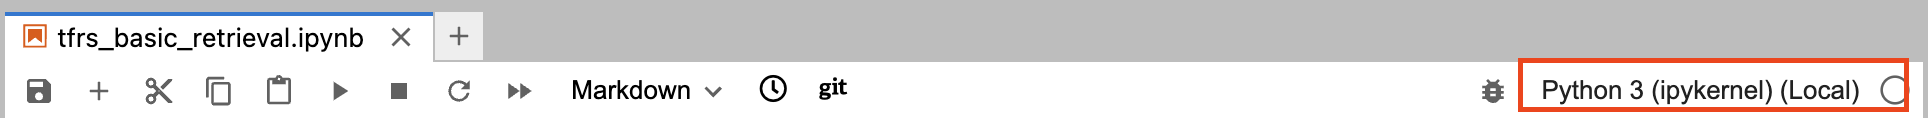

Then select `tf_recommenders_kernel` in the pop-up selector:

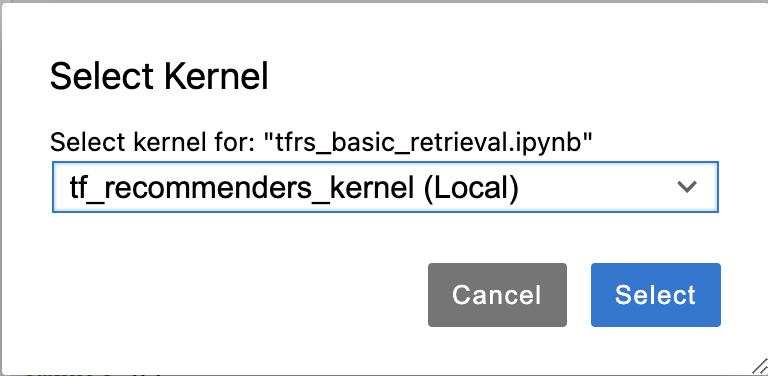

After that you should be able to run the following imports:

In [ ]:
# Importing necessary modules
import os
import warnings

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
warnings.filterwarnings("ignore")

In [1]:
import pprint
import tempfile
from typing import Dict, Text

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
import tensorflow_recommenders as tfrs

## Preparing the dataset

Let's first have a look at the data.

We use the MovieLens dataset from [Tensorflow Datasets](https://www.tensorflow.org/datasets). Loading `movielens/100k_ratings` yields a `tf.data.Dataset` object containing the ratings data and loading `movielens/100k_movies` yields a `tf.data.Dataset` object containing only the movies data.

Note that since the MovieLens dataset does not have predefined splits, all data are under `train` split.

In [3]:
# TODO 1 - Your code is here.
# Ratings data.
ratings = tfds.load(
    "movielens/100k-ratings",
    split="train",
    data_dir="gs://asl-public/data/tensorflow_datasets/",
)
# Features of all the available movies.
movies = tfds.load(
    "movielens/100k-movies",
    split="train",
    data_dir="gs://asl-public/data/tensorflow_datasets/",
)

The ratings dataset returns a dictionary of movie id, user id, the assigned rating, timestamp, movie information, and user information:

In [4]:
# Printing the user information and movie information
for x in ratings.take(1).as_numpy_iterator():
    pprint.pprint(x)

{'bucketized_user_age': 45.0,
 'movie_genres': array([7]),
 'movie_id': b'357',
 'movie_title': b"One Flew Over the Cuckoo's Nest (1975)",
 'raw_user_age': 46.0,
 'timestamp': 879024327,
 'user_gender': True,
 'user_id': b'138',
 'user_occupation_label': 4,
 'user_occupation_text': b'doctor',
 'user_rating': 4.0,
 'user_zip_code': b'53211'}


The movies dataset contains the movie id, movie title, and data on what genres it belongs to. Note that the genres are encoded with integer labels.

In [5]:
# Printing the data on what genres it belongs to
for x in movies.take(1).as_numpy_iterator():
    pprint.pprint(x)

{'movie_genres': array([4]),
 'movie_id': b'1681',
 'movie_title': b'You So Crazy (1994)'}


In this example, we're going to focus on the ratings data. Other notebooks explore how to use the movie information data as well to improve the model quality.

We keep only the `user_id`, and `movie_title` fields in the dataset.

In [6]:
# Here, we are focusing on the ratings data
ratings = ratings.map(
    lambda x: {
        "movie_title": x["movie_title"],
        "user_id": x["user_id"],
    }
)
movies = movies.map(lambda x: x["movie_title"])

To fit and evaluate the model, we need to split it into a training and evaluation set. In an industrial recommender system, this would most likely be done by time: the data up to time $T$ would be used to predict interactions after $T$.


In this simple example, however, let's use a random split, putting 80% of the ratings in the train set, and 20% in the test set.

In [7]:
# Here, using tf.random module to shuffle randomly a tensor in its first dimension
SEED = 42

tf.random.set_seed(SEED)
shuffled = ratings.shuffle(100_000, seed=SEED, reshuffle_each_iteration=False)

train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

Let's also figure out unique user ids and movie titles present in the data. 

This is important because we need to be able to map the raw values of our categorical features to embedding vectors in our models. To do that, we need a vocabulary that maps a raw feature value to an integer in a contiguous range: this allows us to look up the corresponding embeddings in our embedding tables.

In [8]:
# Displaying the corresponding data according to the embedded tables.
movie_titles = movies.batch(1_000)
user_ids = ratings.batch(1_000_000).map(lambda x: x["user_id"])

unique_movie_titles = np.unique(np.concatenate(list(movie_titles)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

unique_movie_titles[:10]

array([b"'Til There Was You (1997)", b'1-900 (1994)',
       b'101 Dalmatians (1996)', b'12 Angry Men (1957)', b'187 (1997)',
       b'2 Days in the Valley (1996)',
       b'20,000 Leagues Under the Sea (1954)',
       b'2001: A Space Odyssey (1968)',
       b'3 Ninjas: High Noon At Mega Mountain (1998)',
       b'39 Steps, The (1935)'], dtype=object)

## Implementing a model

Choosing the architecure of our model a key part of modelling.

Because we are building a two-tower retrieval model, we can build each tower separately and then combine them in the final model.

### The query tower

Let's start with the query tower.

The first step is to decide on the dimensionality of the query and candidate representations:

In [9]:
embedding_dimension = 32

Higher values will correspond to models that may be more accurate, but will also be slower to fit and more prone to overfitting.

The second is to define the model itself. Here, we're going to use Keras preprocessing layers to first convert user ids to integers, and then convert those to user embeddings via an `Embedding` layer. Note that we use the list of unique user ids we computed earlier as a vocabulary:

In [10]:
user_model = tf.keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.StringLookup(
            vocabulary=unique_user_ids, mask_token=None
        ),
        # We add an additional embedding to account for unknown tokens.
        tf.keras.layers.Embedding(
            len(unique_user_ids) + 1, embedding_dimension
        ),
    ]
)

While defining a subclass of `tf.keras.Model` for this simple model might be overkill, we can easily extend it to an arbitrarily complex model using standard Keras components, as long as we return an `embedding_dimension`-wide output at the end.

### The candidate tower

We can do the same with the candidate tower.

In [11]:
movie_model = tf.keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.StringLookup(
            vocabulary=unique_movie_titles, mask_token=None
        ),
        tf.keras.layers.Embedding(
            len(unique_movie_titles) + 1, embedding_dimension
        ),
    ]
)

### Metrics

In our training data, we have positive (user, movie) pairs, which means pairs with actual ratings. To figure out how good our model is, we need to compare the affinity score that the model calculates for this pair to the scores of all the other possible candidates (all movies): if the classification score for the positive pair is higher than for all other candidates, we can understand our model is highly accurate.

To do this, we can use the `tfrs.metrics.FactorizedTopK` metric. The metric has one required argument: the dataset of candidates that are used as implicit negatives (movie candidates that don't have explicit ratings) for evaluation.
In our case, that's the `movies` dataset, converted into embeddings via our movie model.

`FactorizedTopK` automatically computes multiple metrics, which is by default top [1, 5, 10, 50, 100] [`TopKCategoricalAccuracy`](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/TopKCategoricalAccuracy).<br>
Top K accuracy represents the ratio of positive pairs correctly ranked in top K over all the negative candidates (all movies in this case).

In [12]:
# Here, tfrs.metrics.FactorizedTopK function computes metrics for across top K candidates surfaced by a retrieval model.
metrics = tfrs.metrics.FactorizedTopK(
    candidates=movies.batch(128).map(movie_model)
)

### Loss

The next component is the loss used to train our model. TFRS has several loss layers and tasks to make this easy.

In this instance, we'll make use of the `tfrs.task.Retrieval` task object: a convenience wrapper that bundles together the loss function and metric computation.

Under the hood, the `Retrieval` task layer computes scores by multiplying query embedding and candidate embdedding, and outputs loss (by default, Cross-Entropy loss).<br>
Optionally, you can provide metrics and compute them during the training.

In [13]:
# TODO 2 - Your code is here.
# Here, the function bundles together the loss function and metric computation.
task = tfrs.tasks.Retrieval(metrics=metrics)

The task itself is a Keras layer that takes the query and candidate embeddings as arguments, and returns the computed loss: we'll use that to implement the model's training loop.

### The full model

We can now put it all together into a model. TFRS exposes a base model class (`tfrs.models.Model`) which streamlines bulding models: all we need to do is to set up the components in the `__init__` method, and implement the `compute_loss` method, taking in the raw features and returning a loss value.

The base model will then take care of creating the appropriate training loop to fit our model.

In [14]:
class MovielensModel(tfrs.Model):
    def __init__(self, user_model, movie_model):
        super().__init__()
        self.movie_model: tf.keras.Model = movie_model
        self.user_model: tf.keras.Model = user_model
        self.task: tf.keras.layers.Layer = task

    def compute_loss(self, features, training=False):
        # We pick out the user features and pass them into the user model.
        user_embeddings = self.user_model(features["user_id"])
        # And pick out the movie features and pass them into the movie model,
        # getting embeddings back.
        positive_movie_embeddings = self.movie_model(features["movie_title"])

        # The task computes the loss and the metrics.
        return self.task(user_embeddings, positive_movie_embeddings)

The `tfrs.Model` base class is a simple and convenient: it allows us to compute both training and test losses using the same method.

Under the hood, it's still a plain Keras model. You could achieve the same functionality by inheriting from `tf.keras.Model` and overriding the `train_step` and `test_step` functions (see [the guide](https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit) for details) like this:


```python
class MovielensModel(tf.keras.Model):
    def __init__(self, user_model, movie_model):
        super().__init__()
        self.movie_model: tf.keras.Model = movie_model
        self.user_model: tf.keras.Model = user_model
        self.task: tf.keras.layers.Layer = task

    def train_step(self, features):

        # Set up a gradient tape to record gradients.
        with tf.GradientTape() as tape:

            # Loss computation.
            user_embeddings = self.user_model(features["user_id"])
            positive_movie_embeddings = self.movie_model(
                features["movie_title"]
            )
            loss = self.task(user_embeddings, positive_movie_embeddings)

            # Handle regularization losses as well.
            regularization_loss = sum(self.losses)

            total_loss = loss + regularization_loss

        gradients = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        metrics = {metric.name: metric.result() for metric in self.metrics}
        metrics["loss"] = loss
        metrics["regularization_loss"] = regularization_loss
        metrics["total_loss"] = total_loss

        return metrics

    def test_step(self, features):

        # Loss computation.
        user_embeddings = self.user_model(features["user_id"])
        positive_movie_embeddings = self.movie_model(features["movie_title"])
        loss = self.task(user_embeddings, positive_movie_embeddings)

        # Handle regularization losses as well.
        regularization_loss = sum(self.losses)

        total_loss = loss + regularization_loss

        metrics = {metric.name: metric.result() for metric in self.metrics}
        metrics["loss"] = loss
        metrics["regularization_loss"] = regularization_loss
        metrics["total_loss"] = total_loss

        return metrics
```



In these notebooks, however, we stick to using the `tfrs.Model` base class to keep our focus on modelling and abstract away some of the boilerplate.

## Fitting and evaluating

After defining the model, we can use standard Keras fitting and evaluation routines to fit and evaluate the model.

Let's first instantiate the model.

In [15]:
# Compiling the model.
model = MovielensModel(user_model, movie_model)
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

Then shuffle, batch, and cache the training and evaluation data.

In [16]:
cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()

Then train the  model:

In [17]:
# TODO 3a - Your code is here.
# Training the model.
model.fit(cached_train, epochs=3)

Epoch 1/3
10/10 [==============================] - 12s 643ms/step - factorized_top_k/top_1_categorical_accuracy: 1.5000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0024 - factorized_top_k/top_10_categorical_accuracy: 0.0062 - factorized_top_k/top_50_categorical_accuracy: 0.0590 - factorized_top_k/top_100_categorical_accuracy: 0.1303 - loss: 69818.3991 - regularization_loss: 0.0000e+00 - total_loss: 69818.3991
Epoch 2/3
10/10 [==============================] - 6s 567ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0010 - factorized_top_k/top_5_categorical_accuracy: 0.0121 - factorized_top_k/top_10_categorical_accuracy: 0.0275 - factorized_top_k/top_50_categorical_accuracy: 0.1435 - factorized_top_k/top_100_categorical_accuracy: 0.2662 - loss: 67458.0007 - regularization_loss: 0.0000e+00 - total_loss: 67458.0007
Epoch 3/3
10/10 [==============================] - 6s 577ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0015 - factorized_top_k/top_5_categorical_accur

As the model trains, the loss is falling and a set of top-k retrieval metrics is updated. These tell us whether the true positive is in the top-k retrieved items from the entire candidate set. For example, a top-5 categorical accuracy metric of 0.2 would tell us that, on average, the true positive is in the top 5 retrieved items 20% of the time.

Note that, in this example, we evaluate the metrics during training as well as evaluation. Because this can be quite slow with large candidate sets, it may be prudent to turn metric calculation off in training, and only run it in evaluation.

Finally, we can evaluate our model on the test set:

In [18]:
# TODO 3b - Your code is here.
# Evaluating the model.
model.evaluate(cached_test, return_dict=True)

5/5 [==============================] - 5s 338ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0013 - factorized_top_k/top_5_categorical_accuracy: 0.0086 - factorized_top_k/top_10_categorical_accuracy: 0.0214 - factorized_top_k/top_50_categorical_accuracy: 0.1239 - factorized_top_k/top_100_categorical_accuracy: 0.2339 - loss: 31094.2777 - regularization_loss: 0.0000e+00 - total_loss: 31094.2777


{'factorized_top_k/top_1_categorical_accuracy': 0.0013000000035390258,
 'factorized_top_k/top_5_categorical_accuracy': 0.008550000376999378,
 'factorized_top_k/top_10_categorical_accuracy': 0.02135000005364418,
 'factorized_top_k/top_50_categorical_accuracy': 0.12394999712705612,
 'factorized_top_k/top_100_categorical_accuracy': 0.23389999568462372,
 'loss': 28273.32421875,
 'regularization_loss': 0,
 'total_loss': 28273.32421875}

Test set performance is much worse than training performance. This is due to two factors:

1. Our model is likely to perform better on the data that it has seen, simply because it can memorize it. This overfitting phenomenon is especially strong when models have many parameters. It can be mediated by model regularization and use of user and movie features that help the model generalize better to unseen data.
2. The model is re-recommending some of users' already watched movies. These known-positive watches can crowd out test movies out of top K recommendations.

The second phenomenon can be tackled by excluding previously seen movies from test recommendations. This approach is relatively common in the recommender systems literature, but we don't follow it in these notebooks. If not recommending past watches is important, we should expect appropriately specified models to learn this behaviour automatically from past user history and contextual information. Additionally, it is often appropriate to recommend the same item multiple times (say, an evergreen TV series or a regularly purchased item).

## Making predictions

Now that we have a model, we would like to be able to make predictions. We can use the `tfrs.layers.factorized_top_k.BruteForce` layer to do this.

In [19]:
# Create a model that takes in raw query features, and
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
# recommends movies out of the entire movies dataset.
index.index_from_dataset(
    tf.data.Dataset.zip(
        (movies.batch(100), movies.batch(100).map(model.movie_model))
    )
)

# Get recommendations.
_, titles = index(tf.constant(["42"]))
print(f"Recommendations for user 42: {titles[0, :3]}")

Recommendations for user 42: [b"Kid in King Arthur's Court, A (1995)"
 b'Bedknobs and Broomsticks (1971)' b'Aristocats, The (1970)']


Of course, the `BruteForce` layer is going to be too slow to serve a model with many possible candidates. The following sections shows how to speed this up by using an approximate retrieval index.

## Model serving

After the model is trained, we need a way to deploy it.

In a two-tower retrieval model, serving has two components:

- a serving query model, taking in features of the query and transforming them into a query embedding, and
- a serving candidate model. This most often takes the form of an approximate nearest neighbours (ANN) index which allows fast approximate lookup of candidates in response to a query produced by the query model.

In TFRS, both components can be packaged into a single exportable model, giving us a model that takes the raw user id and returns the titles of top movies for that user. This is done via exporting the model to a `SavedModel` format, which makes it possible to serve using [TensorFlow Serving](https://www.tensorflow.org/tfx/guide/serving).

To deploy a model like this, we simply export the `BruteForce` layer we created above:

In [20]:
# TODO 4 - Your code is here.
# Export the query model.
with tempfile.TemporaryDirectory() as tmp:
    path = os.path.join(tmp, "model")

    # Save the index.
    tf.saved_model.save(index, path)

    # Load it back; can also be done in TensorFlow Serving.
    loaded = tf.saved_model.load(path)

    # Pass a user id in, get top predicted movie titles back.
    scores, titles = loaded(["42"])

    print(f"Recommendations: {titles[0][:3]}")

INFO:tensorflow:Assets written to: /var/tmp/tmp15106khc/model/assets


INFO:tensorflow:Assets written to: /var/tmp/tmp15106khc/model/assets


Recommendations: [b"Kid in King Arthur's Court, A (1995)"
 b'Bedknobs and Broomsticks (1971)' b'Aristocats, The (1970)']


We can also export an approximate retrieval index to speed up predictions. This will make it possible to efficiently surface recommendations from sets of tens of millions of candidates.

To learn more about using and tuning fast approximate retrieval models, have a look at our [efficient serving](https://tensorflow.org/recommenders/examples/efficient_serving) notebook.

## Next steps

This concludes the retrieval notebook.

To expand on what is presented here, have a look at:

1. Learning multi-task models: jointly optimizing for ratings and clicks.
2. Using movie metadata: building a more complex movie model to alleviate cold-start.